<a id="title_ID"></a>
# Astrochemistry Summer School, Groningen 2024 #

**Authors**: Aditya M. Arabhavi, Inga Kamp, <br>
If the tools are useful for your science, we kindly ask you to cite the following where relevant:<br>
- [Arabhavi et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024Sci...384.1086A/abstract), for the modeling tools <br>
- [Gordon et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022JQSRT.27707949G/abstract), for the HITRAN spectroscopic data

**Contact**: arabhavi@astro.rug.nl or kamp@astro.rug.nl
<br>
**Last Update**: 09 August 2024
<br>
**Compatible prodimopy versions**: >= 2.3.1

**Table of contents**
* [0. Imports and setup](#0.-Imports-and-setup)
* [1. Understanding molecular spectra](#1.-Understanding-molecular-spectra)
    - [1.1. Task 1](#1.1.-Task-1)

# 0. Imports and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import prodimopy.read_slab as rs
import prodimopy.plot_slab as ps
import prodimopy.run_slab as runs
import prodimopy.hitran as ht
import matplotlib as mpl
from scipy.constants import c,k,h
from scipy.constants import astronomical_unit as au
from scipy.constants import parsec as pc
# from mpl_point_clicker import clicker
from scipy.interpolate import CubicSpline
import pybaselines as pb
from spectres import spectres
import scipy as sp
from os.path import join
import pandas as pd

# Use the entire available screen width for the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

The python plots (later down the notebook), can be made interactive by running either of the following lines. You can run either to check which one works for you

In [2]:
%matplotlib ipympl

In [3]:
%matplotlib notebook

# 1. Understanding molecular spectra

<img style="float: left; padding-right:1%" src='https://phys.libretexts.org/@api/deki/files/10010/CNX_UPhysics_42_02_Trans.jpg?revision=1' alt="Rovib" width="25%"/> 
The figure on the left shows the different energy levels that can be occupied by a molecule. Each level is identified by a combination of quantum numbers. You can this of this like an address of a molecular state. Like having multiple buildings in a street, and multiple apartments within a building, each electronic state can have multiple vibrational energy levels, and each vibrational level can have multiple rotational levels.<br>
The energy difference between the electronic states are higher than the energy difference between the vibrational states, which is higher than the difference between the rotational states <br> <br>
ΔE<sub>elec</sub>>ΔE<sub>vib</sub>>ΔE<sub>rot</sub><br><br>
A molecular energy transition is defined as a change in the energy level of a molecule from one 'address' to another 'address'. Let's call them E<sub>u</sub> and E<sub>l</sub>, for the upper and lower energy levels. The net change in the energy (ΔE<sub>ul</sub>) is E<sub>u</sub>-E<sub>l</sub> for a transition from upper to lower energy level. This change in energy is released in the form of a single photon whose frequency can be defined as 𝜈<sub>ul</sub>=ΔE<sub>ul</sub>/h (where h is the planck's constant).<br>

However, in reality we do not observe the transition of a single molecule in space, but a transitions of several molecules in a given line of sight. That is, we observe multiple molecules transitioning from energy level A to B, another set of molecules from A to C, another set from B to C, etc. Each set here would correspond to different frequency, which gives rise to the fingerprints of the molecules, or the molecular spectra. To calculate the molecular emission or absorption spectrum, we need a few ingredients: <br>
&nbsp;&nbsp;&nbsp;   1. the energy of each level, e.g., E<sub>1</sub>, E<sub>2</sub>, ..., E<sub>n</sub> for 'n' levels.<br>
&nbsp;&nbsp;&nbsp;   2. the population or the number of molecules in each 'address' or energy level.<br>
&nbsp;&nbsp;&nbsp;   3. probability of transition by photon emission/absorption from one energy level to the other, called the Einstein A coefficient: A<sub>ul</sub>, for a transition from energy state u to l.<br>
&nbsp;&nbsp;&nbsp;   4. denegeracy of the energy level or number of duplicate addresses.<br>
Part of these ingredients (particularly 1,3,4) can be obtained from different databases that either provide these based on quantum chemistry calculations or laboratory measurements. For the purposes of this exercise we will use the data from the <a href="https://hitran.org/">HITRAN spectroscopic database</a>.<br>
You can find the HITRAN spectroscopic data of several molecules in <code>astrochemschool2024/src/data/hitran/</code>.<br>
In local thermodynamic equlibrium (LTE), we can assume that the population (p) of the energy levels follow the <a href="https://en.wikipedia.org/wiki/Boltzmann_distribution">Boltzmann distribution</a>. To calculate this, we need the energy (E) and degeneracy (g) of each level, the temperature (T) of the molecules and the partition sums (Q). Latter is provided in the database.<br>
$$p = \frac{g\ e^{-E/T}}{Q} $$

Let us read in some data from HITRAN and build our own molecular spectra!<br>
Take a look at the list of molecules at <code>astrochemschool2024/src/data/hitran/</code> and pick your favorite.

In [4]:
molecule = 'H2O' # use the exact name as provided in the hitran directory
mol_mas = 18 # you need to know/find the molecular mass in atomic mass units. If you are not sure search search online or use online tools such as https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm
temperature = 300 # in Kelvin
isotopologue = [1] # let us select only the main isotopologue of the molecule

# Do not change the below code unless you know exactly what you are doing
filepath = '../src/data/hitran/'+molecule+'.par'
QTpath = '../src/data/QTpy/'

In [5]:
mol_data = ht.read_hitran(filepath,
                          molecule,
                          isotopologue,
                          lowerLam=16, higherLam=18) # wavelength limits in microns

/net/dataserver3/data/users/arabhavi/.conda/envs/astrochem2024/lib/python3.11/site-packages/prodimopy/hitran.py:503: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['line_mixing']=data['line_mixing'].fillna(False)


Use <code>mol_data.keys()</code> in a separate cell, to see different columns of the data. In the following we only include the relevant ones

In [6]:
include = ['lambda','A','E_u','E_l','global_u','global_l','local_u','local_l','g_u','g_l']
mol_data[include]

,lambda,A,E_u,E_l,global_u,global_l,local_u,local_l,g_u,g_l
22747,16.000010,2.869000e-01,5132.522307,4507.5227,0 1 0,0 1 0,15 6 10,15 3 13,31.0,31.0
22746,16.004690,1.002000e+02,4796.969164,4172.1523,0 0 0,0 0 0,15 12 3,14 11 4,93.0,87.0
22745,16.004690,1.002000e+02,4796.969159,4172.1523,0 0 0,0 0 0,15 12 4,14 11 3,31.0,29.0
22742,16.011221,5.829000e+01,4830.893873,4206.3319,0 0 0,0 0 0,17 9 8,16 8 9,105.0,99.0
22738,16.016349,2.505000e-01,5442.097824,4817.7358,0 0 1,0 0 1,10 5 5,9 2 8,63.0,57.0
...,...,...,...,...,...,...,...,...,...,...
21726,17.968006,6.411000e-03,4889.457083,4332.9123,1 0 0,0 0 1,8 5 4,7 1 7,51.0,45.0
21724,17.970464,6.227000e-05,3997.508257,3441.0396,0 1 0,0 1 0,10 8 3,11 3 8,63.0,69.0
21720,17.978484,1.169000e-08,2246.884827,1690.6644,0 0 0,0 0 0,13 2 11,11 2 9 q,81.0,69.0
21714,17.994847,1.505000e-03,4847.622151,4291.9075,0 1 0,0 0 0,16 3 14,17 6 11,99.0,105.0


Here each row corresponds to a line transition of your favorite molecule. 'lambda' is the wavelength \[microns\], 'A' is the Einstein A coefficient \[s<sup>-1</sup>\], 'E_u', 'E_l' are the upper and lower energy levels \[cm<sup>-2</sup>\], 'global_u', 'global_l' are the quantum numbers (addresses) of the vibrational levels, 'local_u', 'local_l' are the quantum numbers of the rotational levels, 'g_u', 'g_l' are the degeneracies of the upper and lower energy levels.<br><br>
Let us visualize this by plotting the upper energy levels against the wavelength, colored by the Einstein A coefficients. What do you observe?

<IPython.core.display.Javascript object>


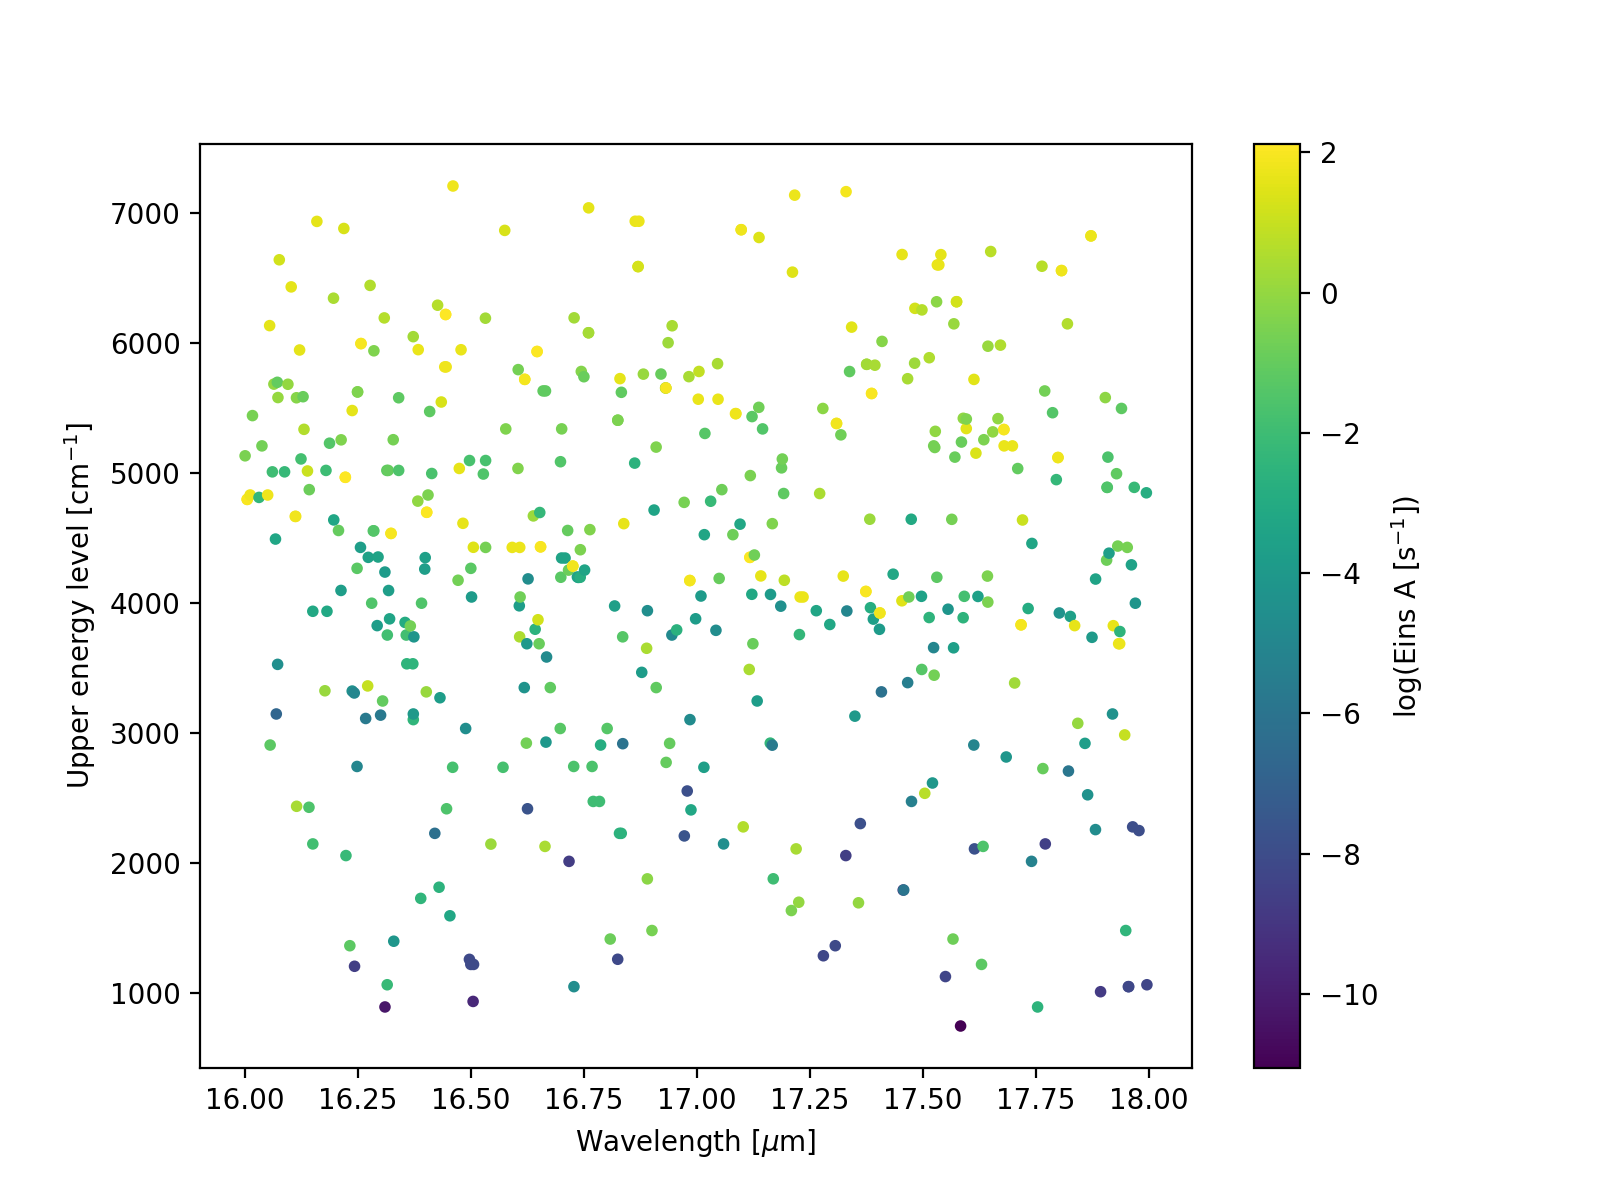

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [7]:
fig,ax = plt.subplots(figsize=(8,6))
A = ax.scatter(mol_data['lambda'],mol_data['E_u'],c=np.log10(mol_data['A']),s=10)
cbar = fig.colorbar(A,label='log(Eins A [s$^{-1}$])')
ax.set_ylabel('Upper energy level [cm$^{-1}$]')
ax.set_xlabel('Wavelength [$\mu$m]')


We can visualize the upper and lower energy levels together also illustrating the level transition:

<IPython.core.display.Javascript object>


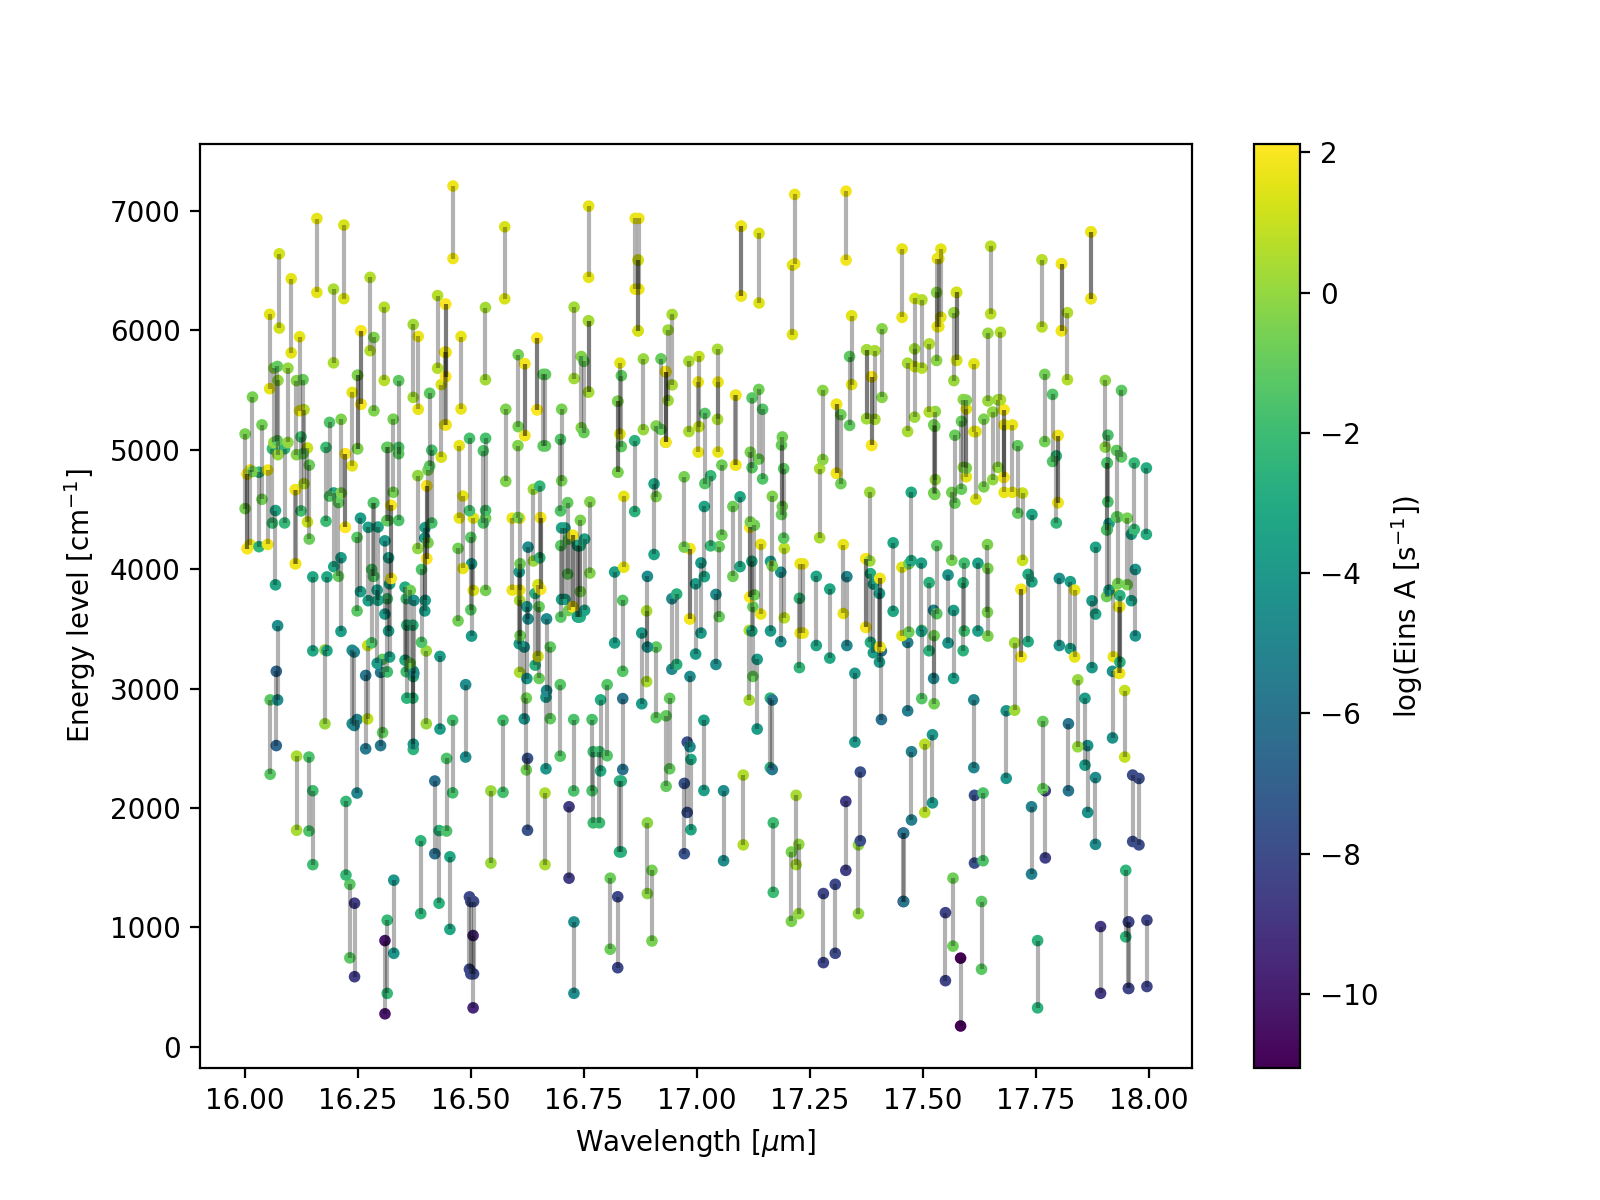

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [8]:
fig,ax = plt.subplots(figsize=(8,6))
A = ax.scatter(mol_data['lambda'],mol_data['E_u'],c=np.log10(mol_data['A']),s=10)
ax.scatter(mol_data['lambda'],mol_data['E_l'],c=np.log10(mol_data['A']),s=10)
ax.vlines(mol_data['lambda'],mol_data['E_l'],mol_data['E_u'],color='k',alpha=0.3)
cbar = fig.colorbar(A,label='log(Eins A [s$^{-1}$])')
ax.set_ylabel('Energy level [cm$^{-1}$]')
ax.set_xlabel('Wavelength [$\mu$m]')


Let us now calculate the level populations

In [9]:
upper_level_population = runs.boltzmann_distribution(mol_data['E_u'],mol_data['g_u'],temperature,runs.fetch_QT(molecule,isotopologue[0],temperature,QTpath))
lower_level_population = runs.boltzmann_distribution(mol_data['E_l'],mol_data['g_l'],temperature,runs.fetch_QT(molecule,isotopologue[0],temperature,QTpath))

Visualize the upper level populations, colored by the energy of those levels. **What do you observe?**<br>
If you color them by the Einstein A coefficients, **what do you see?**


<IPython.core.display.Javascript object>


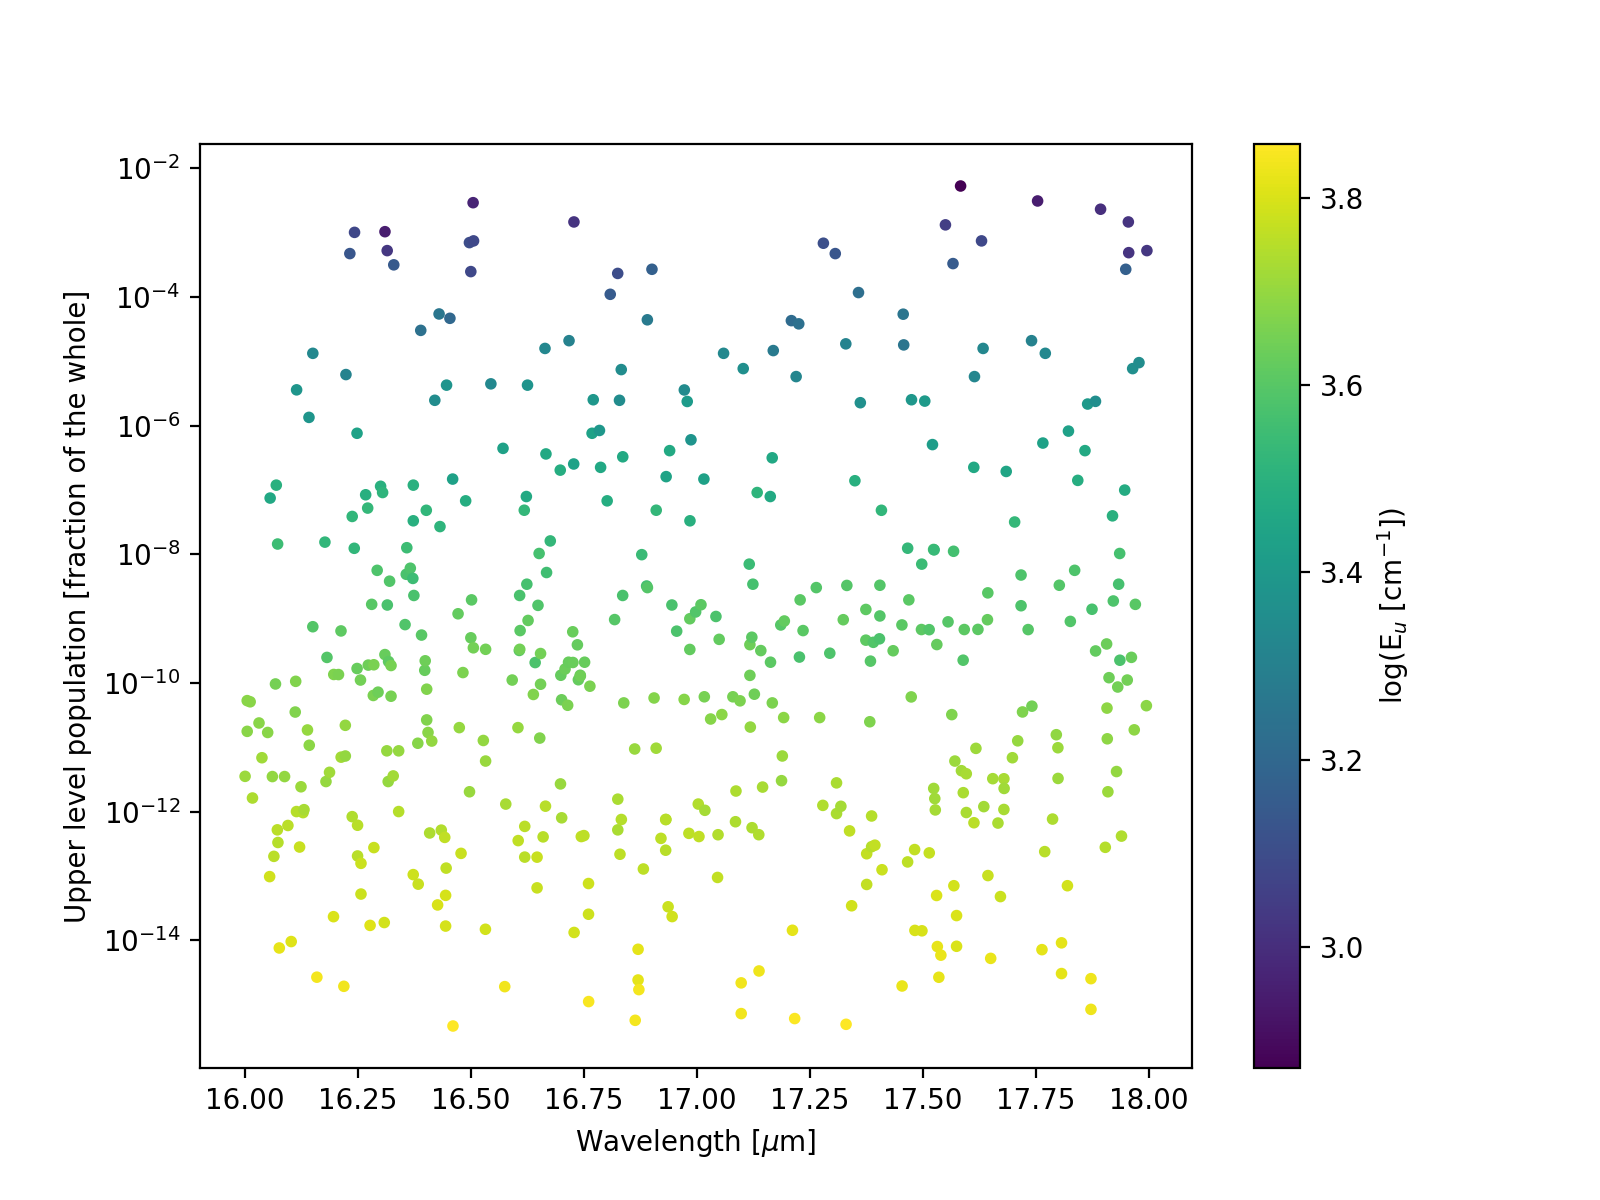

In [10]:
fig,ax = plt.subplots(figsize=(8,6))
A = ax.scatter(mol_data['lambda'],upper_level_population,c=np.log10(mol_data['E_u']),s=10)
cbar = fig.colorbar(A,label='log(E$_u$ [cm$^{-1}$])')
ax.set_ylabel('Upper level population [fraction of the whole]')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_yscale('log')

We are two more steps away from calculating the line intensities or the spectrum. We need to understand the line profile function and the line optical depth.<br>
**Line profile function**: In a gas of kinetic temperature T, the molecules have a large distribution of kinetic energies. i.e., the kinetic temperature represents the mean kinetic energy of the system. Due to this, instead of each molecular transition between E<sub>1</sub> and E<sub>2</sub> having the energy difference of E<sub>u</sub>-E<sub>l</sub> at $\nu_{12}$, there will be a slight variation in these frequencies. For simplicity, we can assume that this distribution is Gaussian in LTE. This means that instead of all transitions emitting at the frequency $\nu_{12}$, the lines follow a Gaussian profile (the line profile function $\phi$) with the mean at $\nu_{12}$ and width $\Delta\nu_D$<br>
$$\phi_{\nu} = \frac{1}{\Delta\nu_{D}\sqrt{\pi}}e^{-\left(\frac{\nu-\nu_{12}}{\Delta\nu_D}\right)}$$
**Line optical depth**: As the number of molecules increase, the number of photons released also increase. However, as the number of molecules in the line of sight increase, there will be inter-molecular absorption of the photons. Due to this only a fraction of the emitted photon actually escape towards the observer. This can be quantified by the captured by calculating the quantity known as optical depth $\tau$. The optical depth at the line center for a column of N molecules per cm$^{-2}$ is given by:
$$\tau_{12}=\frac{N\lambda_{12}^2A_{12}}{8\pi}\left(\frac{g_1}{g_2}p_2-p_1\right)$$
Combining these two, we can write the optical depth at any frequency $\nu$ due to the transition between energy levels 1 to 2 as:
$$\tau_{\nu}=\frac{\tau_{12}}{\Delta\nu_D\sqrt{\pi}}e^{-\left(\frac{\nu-\nu_{12}}{\Delta\nu_D}\right)}$$
<br><br>
Using the radiative transfer equation $\frac{dI_{\nu}}{ds}=j_{\nu}-\kappa_{\nu}J_{\nu}$ ($I_{\nu}$ is the specific intensity, $s$ is the direction, $j_{\nu}$ and $\kappa_{\nu}$ are the emission and absorption coefficients), we can show that the total line intensity ($I$) is given by
$$I = B_{\nu_{12}}(T)C$$
where $B_{\nu_{12}}(T)$ is the Planck function at temperature $T$, and $C$ is the growth factor given by $\int\left(1-e^{-\tau_{\nu}}\right)d\nu$<br>
Below figures show how the factor $1-e^{-\tau_{\nu}}$ which encapsulates the optical depth and the line profile function


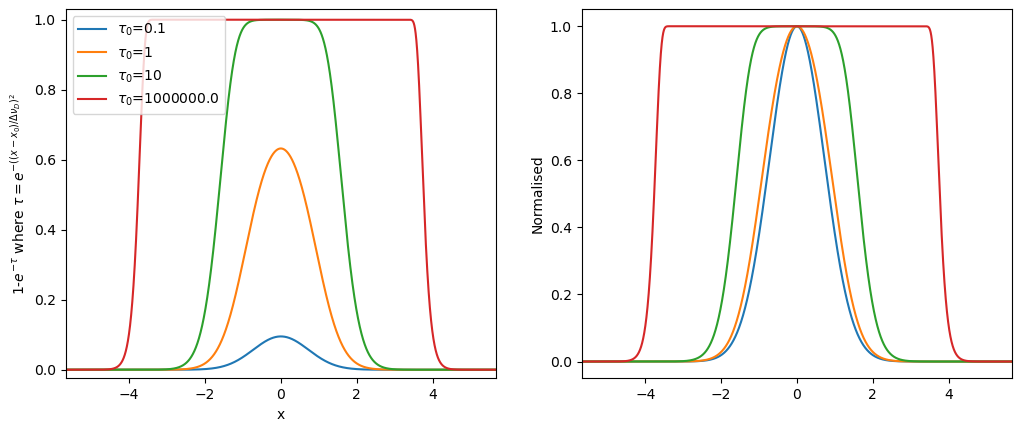

As the optical depth at the line center increases, the factor $1-e^{-\tau_{\nu}}$ increases, and the profile gets broader. At large optical depths, the line center saturates, meaning the line intensity at the line center equals the Planck function (or the blackbody curve). As the opacity increases to even larger values, the line profile becomes even more 'square' shaped.<br>
The integral of this factor, i.e., the growth factor $\int\left(1-e^{-\tau_{\nu}}\right)d\nu$ continues to grow with optical depth, but at a much shallower rate than linear (see below). i.e., as the number of molecules in the line of sight increases, the optical depth increases. At low optical depths, the increase in number of molecules directly increases the line flux; but as the optical depth saturates the line flux increases but much slowly. **Can you explain why the growth factor increases with the optical depth even when the optical depth at the line center saturates pretty quickly?**

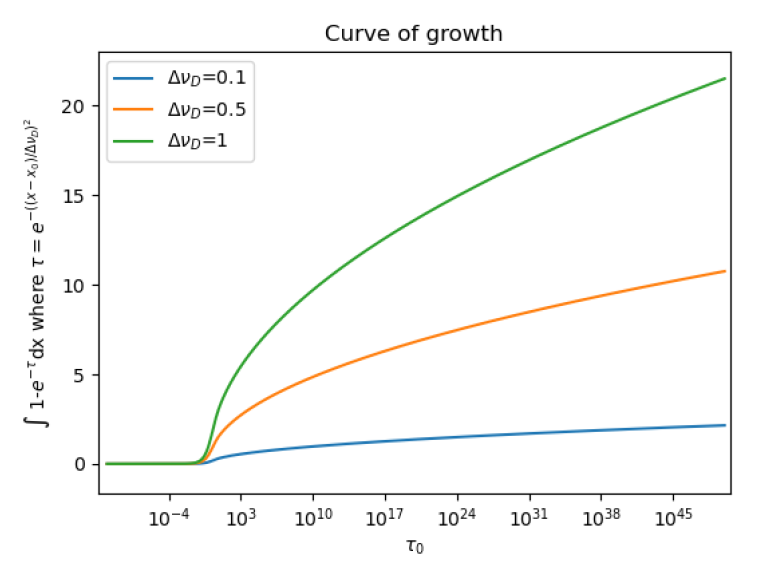

Now that we have all the ingredients, let us calculate the line fluxes of your favorite molecule. We have already implemented all of the above equations into the function <code>prodimopy.runs_slab.run_0d_slab</code>. The following block of code is self-explanatory. The output of the model is stored in <code>outputfile</code>

In [11]:
# enter a name for the output file
outputfile = 'test' # the output file will be outputfile+'.fits.gz.out', so in this case test.fits.gz.out

runs.run_0D_slab(Ng         = 1e18,              # The gas column density in molecules per cm2
                 Tg         = temperature,       # The gas temperature
                 vturb      = 2.0,               # Delta nu_D or the width parameter in km/s
                 molecule   = molecule,          # name of the molecule
                 mol_mass   = mol_mas,           # molecular mass in amu
                 HITRANfile = filepath,          # Path of the HITRAN data file
                 QTpath     = QTpath,            # path of the partition sums
                 output_filename = outputfile,   # output filename (the output file will be output_filename+'.fits.gz.out')
                 isotopolog = isotopologue,      # list of isotopologues to include      
                 wave_mol   = [16,18],           # wavelength region in which the lines are to be picked up
                 overlap    = False,             # Whether or not to include the line opacity overlap, for now turn it off
                 R_grid     = 1e5)               # spectral resolving power for spectrum with opacity overlap, is not used in this case

/net/dataserver3/data/users/arabhavi/.conda/envs/astrochem2024/lib/python3.11/site-packages/prodimopy/hitran.py:503: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['line_mixing']=data['line_mixing'].fillna(False)


The line intensities are now calculated and stored in the output file. We can use the following code to read the output file.

In [12]:
data = rs.read_slab(outputfile+'.fits.gz.out')

Reading slab model output from:  test.fits.gz.out


<code>data</code> now contains the output data. This includes the level data <code>data.leveldata</code> (levels, the level energies, the level populations), and the line data <code>data.linedata</code> (the levels involved in each transition, the level quantum numbers, the optical depths of the line centers, the total line intensities for each transition, etc.). The unit of the total line intensities is erg/s/cm$^{2}$/sr.<br>
You can use the <code>.keys()</code> method to see the other columns that might interest you. Below we show only a few that are relevant for this exercise.

In [13]:
data.leveldata[['g','E','ltepop']]

,g,E,ltepop
0,31.0,5132.5,3.551490e-12
1,31.0,4507.5,7.115180e-11
2,93.0,4797.0,5.326420e-11
3,87.0,4172.2,9.973960e-10
4,31.0,4797.0,1.775470e-11
...,...,...,...
903,69.0,1690.7,1.166130e-04
904,99.0,4847.6,4.447190e-11
905,105.0,4291.9,6.778070e-10
906,15.0,1059.6,5.227570e-04


In [14]:
data.linedata[['Eu','A','GHz','tauLTE','FLTE','global_u', 'global_l', 'local_u', 'local_l']]

,Eu,A,GHz,tauLTE,FLTE,global_u,global_l,local_u,local_l
0,5132.52,2.869000e-01,18737.0,8.622800e-09,1.006760e-11,0 1 0,0 1 0,15 3 13,15 6 10
1,4796.97,1.002000e+02,18731.5,4.516390e-05,5.269390e-08,0 0 0,0 0 0,14 11 4,15 12 3
2,4796.97,1.002000e+02,18731.5,1.505460e-05,1.756580e-08,0 0 0,0 0 0,14 11 3,15 12 4
3,4830.89,5.829000e+01,18723.9,2.520790e-05,2.940160e-08,0 0 0,0 0 0,16 8 9,17 9 8
4,5442.10,2.505000e-01,18717.9,3.466080e-09,4.043550e-12,0 0 1,0 0 1,9 2 8,10 5 5
...,...,...,...,...,...,...,...,...,...
449,4889.46,6.411000e-03,16684.8,1.016060e-09,1.057460e-12,0 0 1,1 0 0,7 1 7,8 5 4
450,3997.51,6.227000e-05,16682.5,8.786970e-10,9.143710e-13,0 1 0,0 1 0,11 3 8,10 8 3
451,2246.88,1.169000e-08,16675.1,9.393300e-10,9.769690e-13,0 0 0,0 0 0,11 2 9 q,13 2 11
452,4847.62,1.505000e-03,16659.9,5.660000e-10,5.880880e-13,0 0 0,0 1 0,17 6 11,16 3 14


You can manually plot the line intensities with wavelength on x-axis by converting the frequencies in GHz to microns, and the line intensities on the y-axis. Or you can also use the pre-built <code>prodimopy.plot_slab.plot_lines()</code> function.

**Option: pre-build function**

<IPython.core.display.Javascript object>


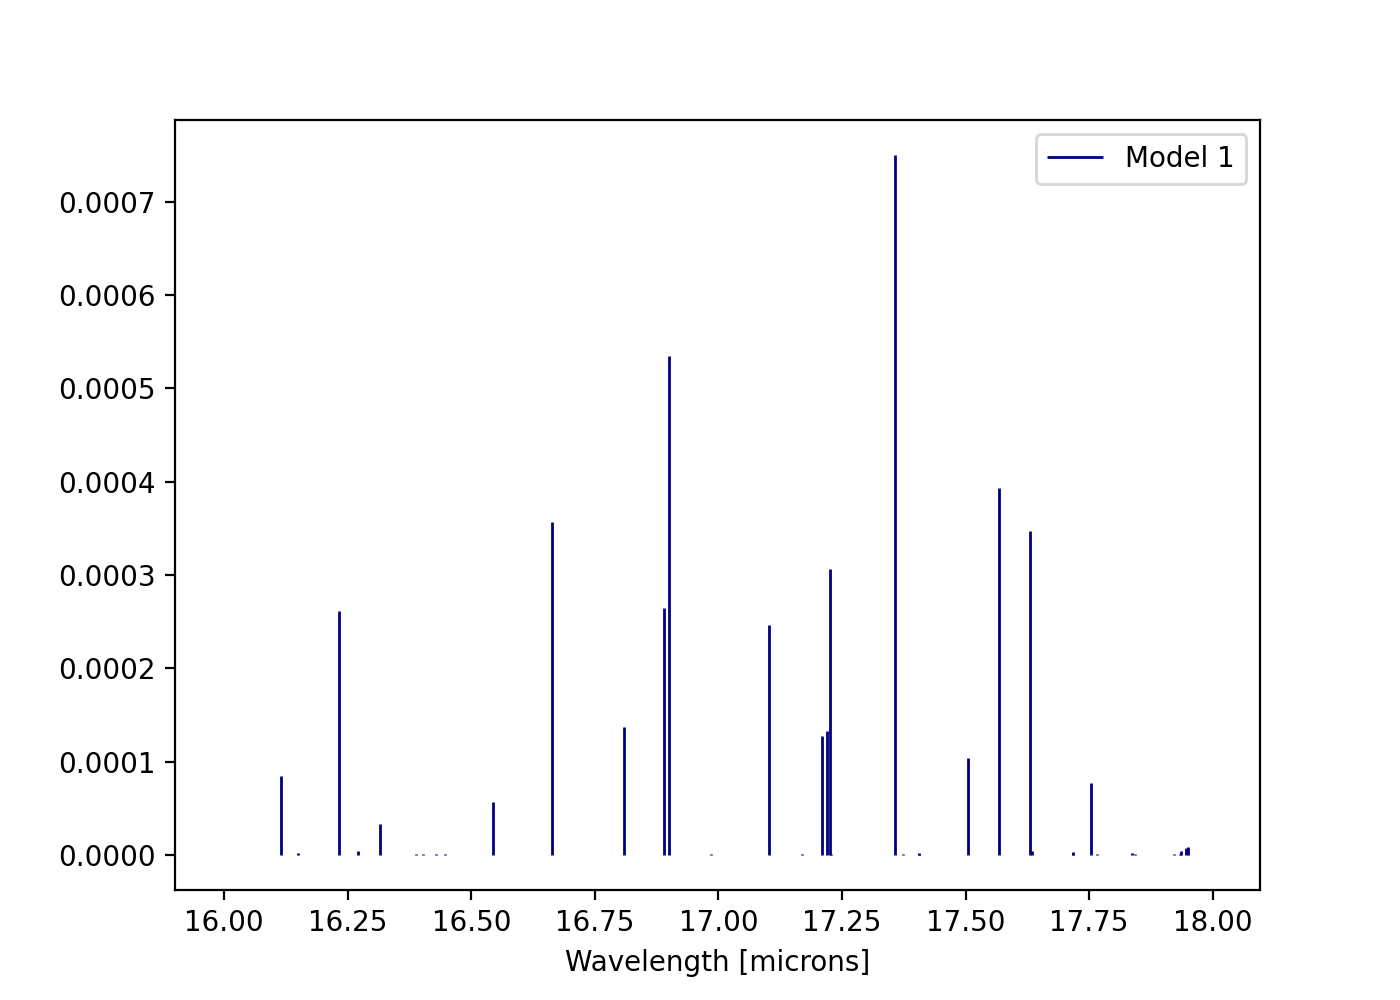

[(<Figure size 700x500 with 1 Axes>, <Axes: xlabel='Wavelength [microns]'>)]

In [15]:
ps.plot_lines(data,label=['Model 1'])

**Option: manual**

<IPython.core.display.Javascript object>


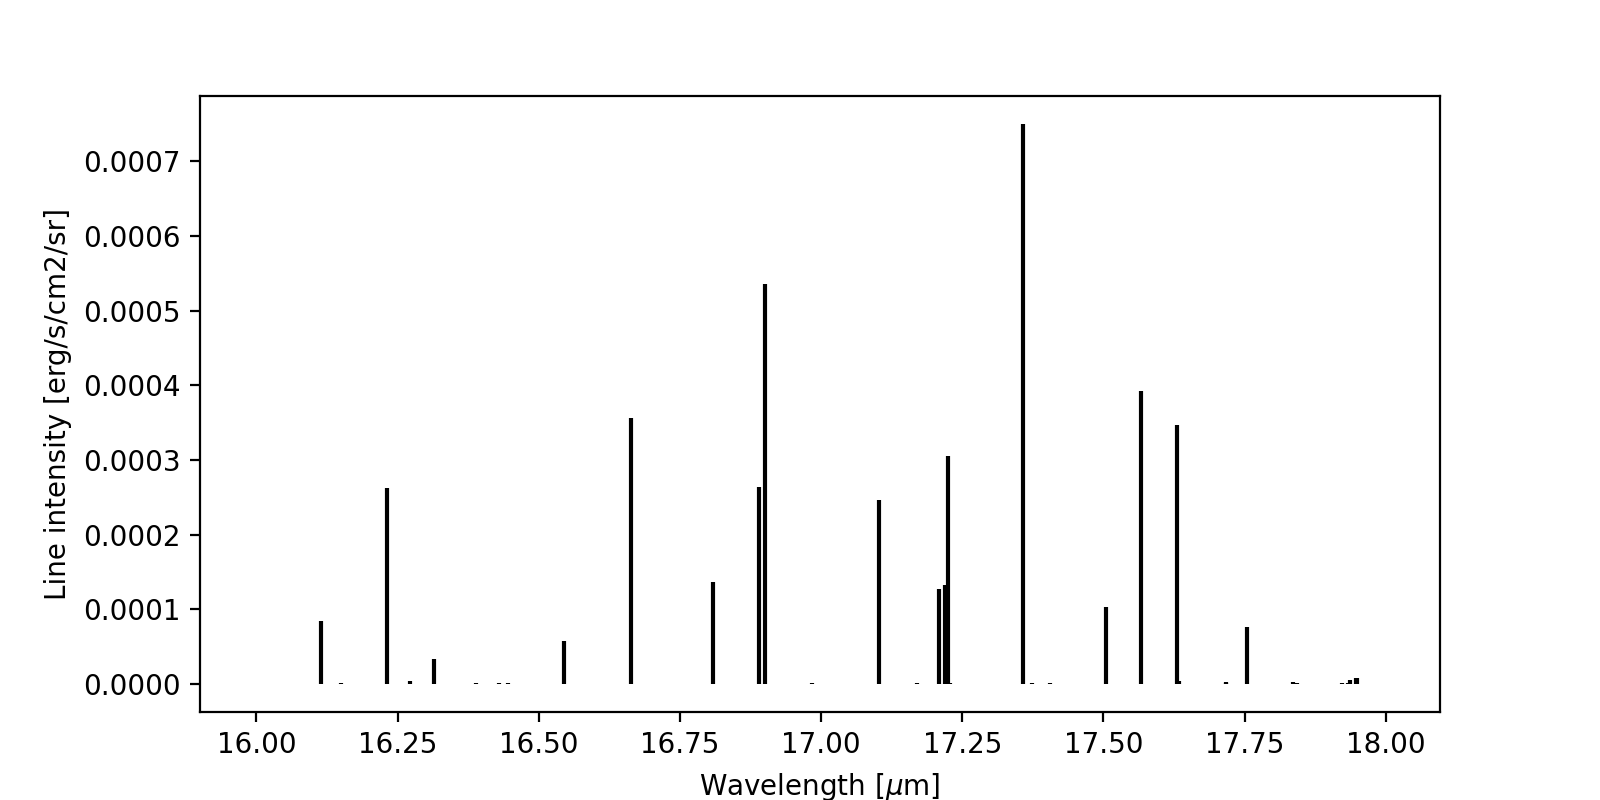

Text(0, 0.5, 'Line intensity [erg/s/cm2/sr]')

In [16]:
fig,ax = plt.subplots(figsize=(8,4))

wavelengths = c/data.linedata['GHz']*1e-3 # Convert GHz to microns, c is the speed of light

ax.vlines(wavelengths,0,data.linedata['FLTE'],color='k',label='Model 1')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Line intensity [erg/s/cm2/sr]')

We next convolve these line intensities on to a wavelength grid that is similar to the spectroscopy tools used to observe the astrophysical environments. Below we convolve the spectra at a spectral resolving power R=3000, representative of the Mid-infrared instrument (MIRI) on the James Webb Space Telescope (JWST). The resulting spectrum will provide the specific intensity (not the total or integrated line intensity) with the units erg/s/cm$^2$/sr/Hz.

In [17]:
data.convolve(R=3000,lambda_0=16,lambda_n=18)


 1 ; Model number  1 ; Species number  1


**Option: pre-build function** <code>prodimopy.plot_slab.plot_spectra()</code>

<IPython.core.display.Javascript object>


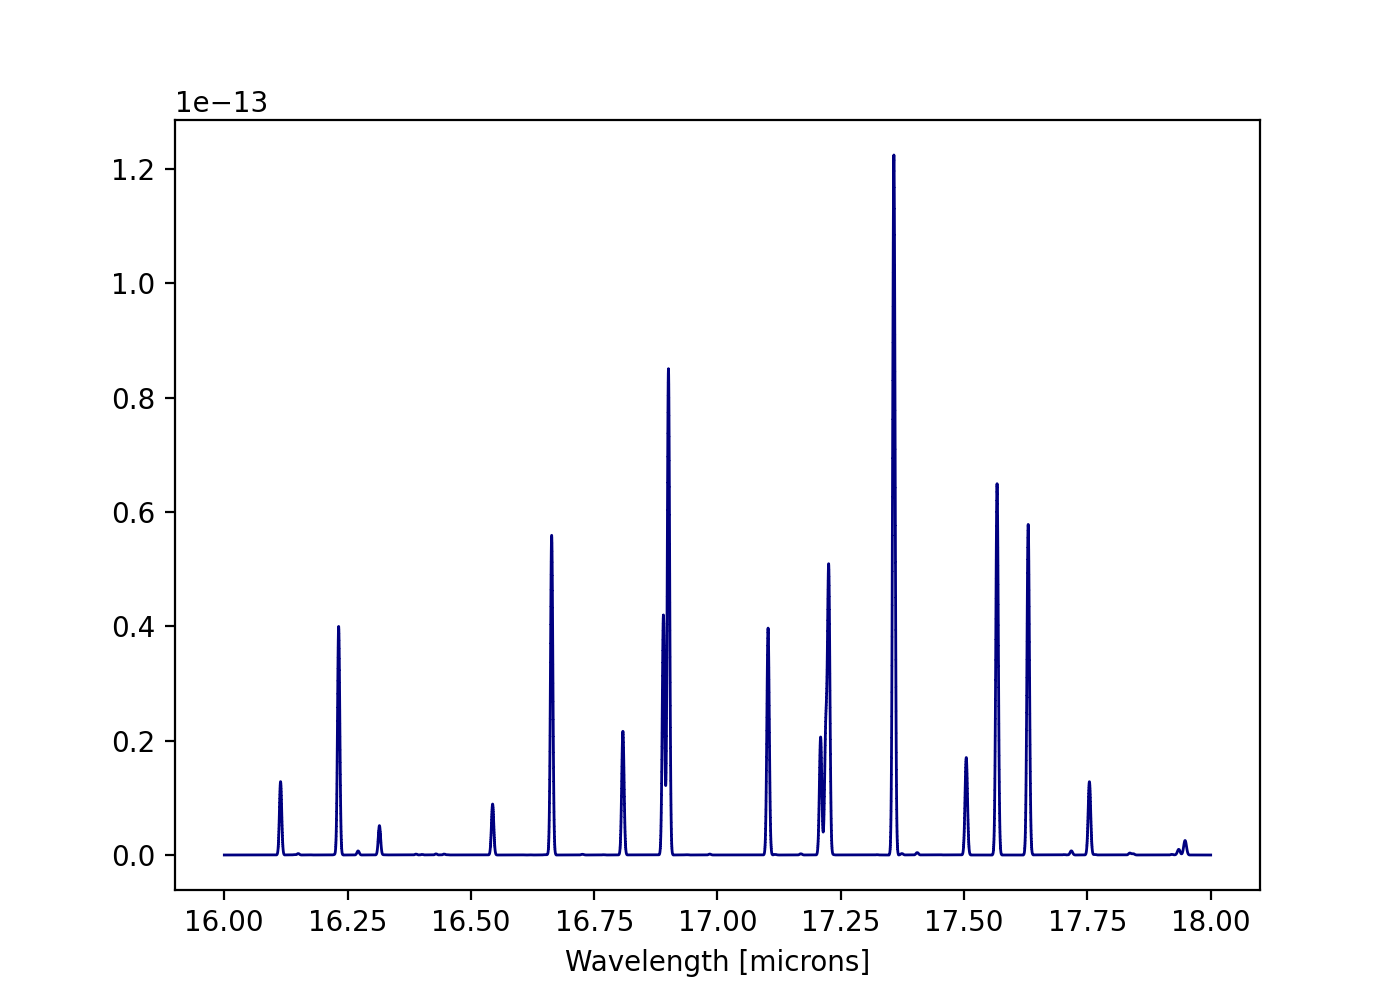

[(<Figure size 700x500 with 1 Axes>, <Axes: xlabel='Wavelength [microns]'>)]

In [18]:
ps.plot_spectra(data)

**Option: manual**

<IPython.core.display.Javascript object>


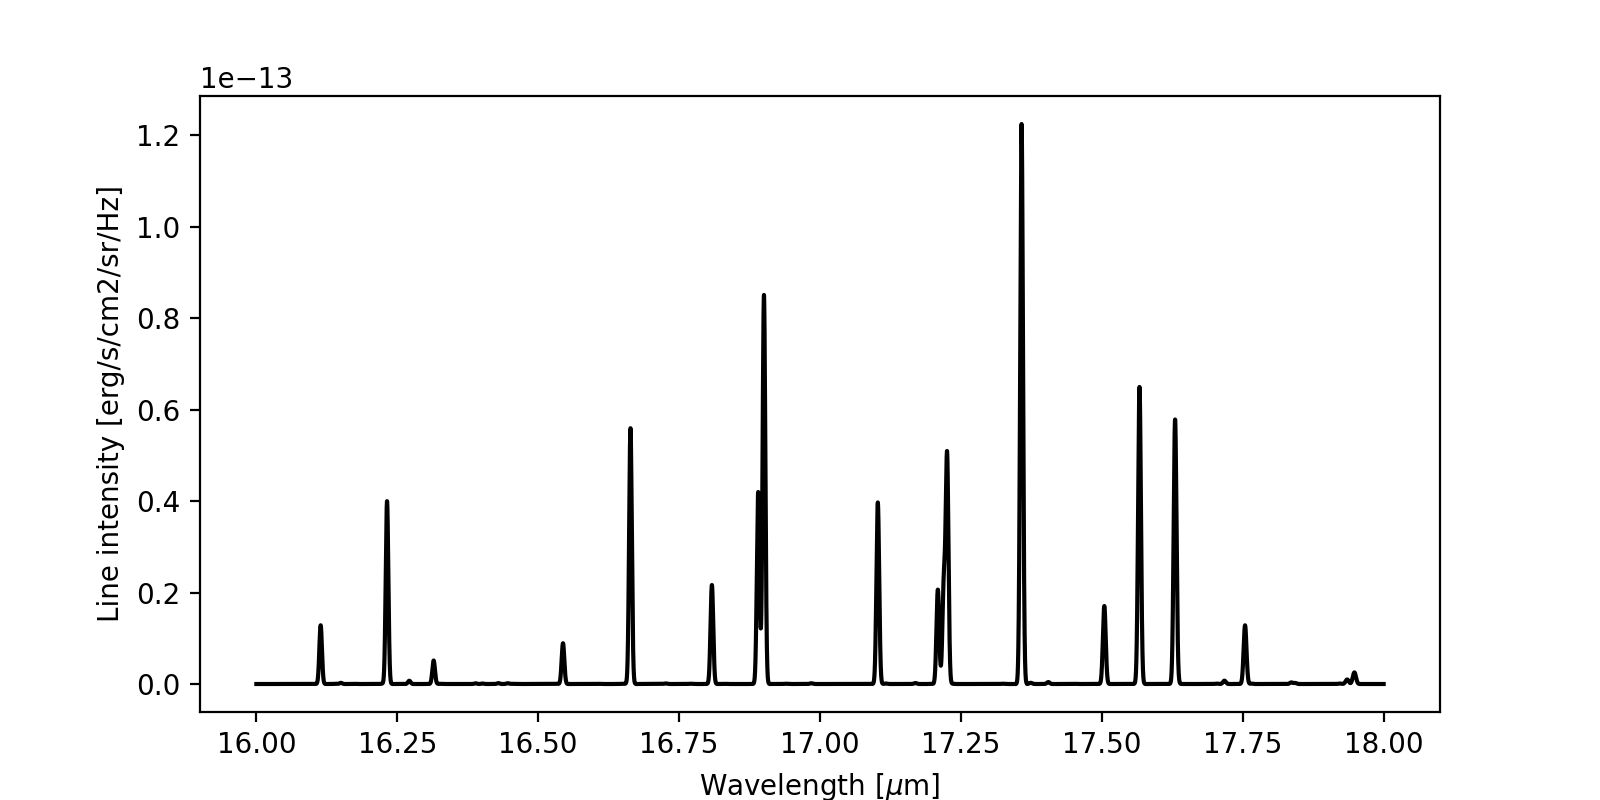

Text(0, 0.5, 'Line intensity [erg/s/cm2/sr/Hz]')

In [19]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(data.convWavelength,data.convLTEflux,color='k',label='Model 1')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Line intensity [erg/s/cm2/sr/Hz]')

## 1.1. Task 1
Calculate the line fluxes for temperatures of 100, 200, 300, 400, 500 K at a column density of $\rm10^{18}\ cm^{-2}$. Read them using the pre-built function as shown before. Convolve the lines to a resolving power of $R=3000$. Normalize the spectra to their peak intensities and plot them in a single window with different colors and labels. Explain the differences observed in these spectra. 

Note: you can read in multiple slab models in a single function call by passing a <code>list</code> of strings containing the file paths. e.g., <code>data = rs.read_slab(['file1.out','file2.out','file3.out'])</code><br>
You can then access individual slab models by <code>data[0]</code>, <code>data[1]</code>, <code>data[2]</code><br>
<code>data.convolve()</code> function will convolve all the slab models with the same settings that you pass. <code>plot_lines</code> and <code>plot_spectra</code> plot all models. To normalise the spectra, and plot in single window see possible arguments that can be passed using the <code>help()</code> function.